In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

0.75970995


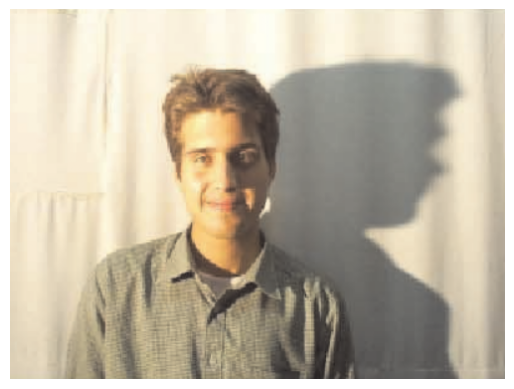

In [2]:
image = plt.imread('project/reference.png')
print(image.mean())
plt.imshow(image)
plt.axis(False)
plt.show()

## Exploração

0.5586067


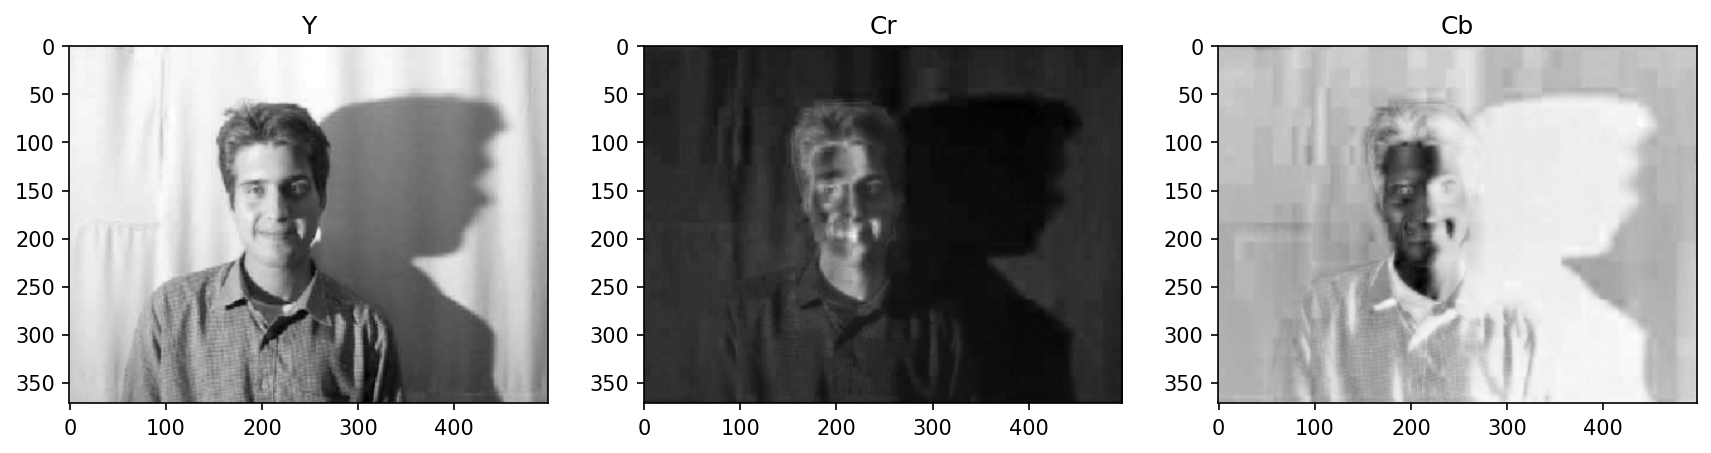

In [3]:
ycc = cv.cvtColor(image, cv.COLOR_RGB2YCR_CB)
print(ycc.mean())
plt.figure(figsize=(14, 10), dpi=150, frameon=True)
plt.subplot(131, title='Y').imshow(ycc[...,0], 'gray')
plt.subplot(132, title='Cr').imshow(ycc[...,1], 'gray')
plt.subplot(133, title='Cb').imshow(ycc[...,2], 'gray')
plt.show()

### lighting_compensation
Top 5% luminance is the reference white

In [4]:
reference_white_pixels = ycc[..., 0] > 0.95
reference_white_pixels

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [5]:
if reference_white_pixels.sum() <= 100:
    print(f'Not Needed ({reference_white_pixels.sum()})')

Seleciona os pixels que são referencia e tira a média das cores

In [6]:
reference_white = image[reference_white_pixels].mean(axis=0)
print(reference_white)
print(1 + (1 - reference_white))

[0.98862183 0.9662249  0.8922735  1.        ]
[1.0113782 1.0337751 1.1077266 1.       ]


Em todos os pixels que não são os de refenrencia

Original RGB: [0.73261875 0.69252634 0.6136945  1.        ]
Corrected RGB: [0.7407683  0.71547836 0.6792176  1.        ]


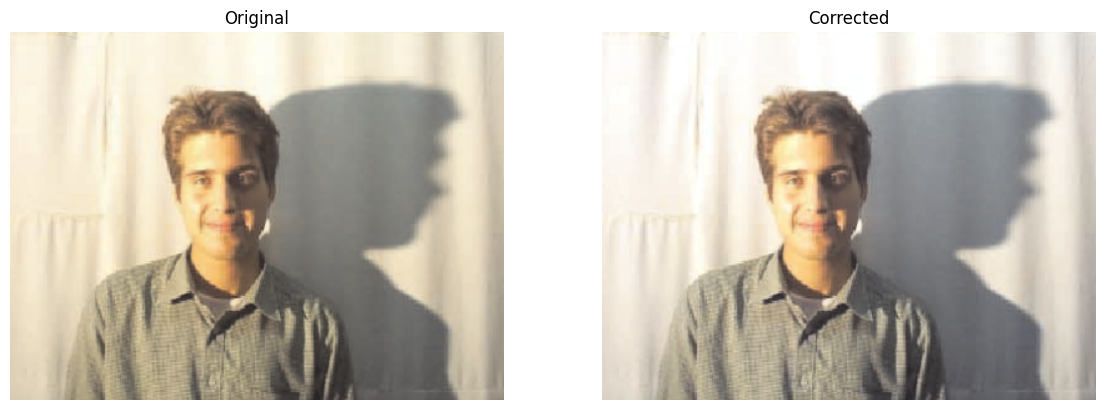

In [7]:
lux_corrected_image = (image * (1 + (1 - reference_white))).clip(0, 1)

print('Original RGB:', image.mean(0).mean(0))
print('Corrected RGB:', lux_corrected_image.mean(0).mean(0))

plt.figure(figsize=(14,10))
plt.subplot(121, title='Original').imshow(image).axes.axis(False)
plt.subplot(122, title='Corrected').imshow(lux_corrected_image).axes.axis(False)
plt.show()

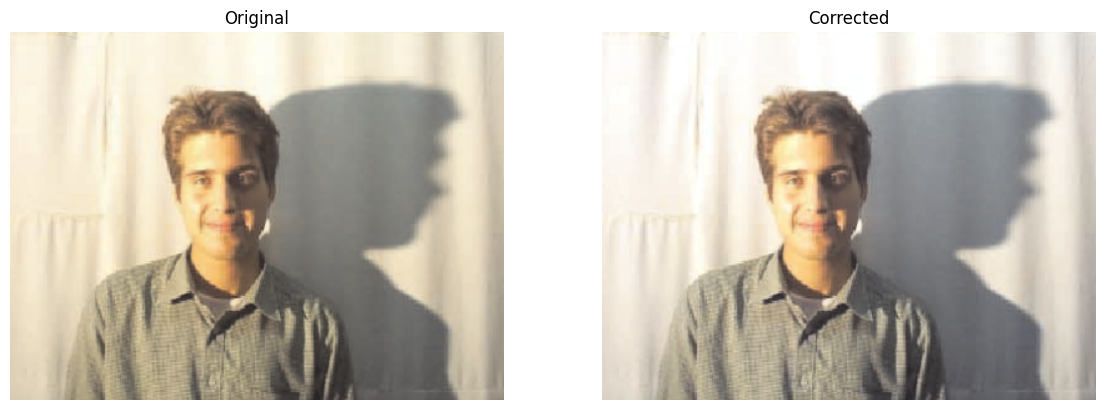

In [8]:
def light_compensation(image):
    ycc = cv.cvtColor(image, cv.COLOR_RGB2YCR_CB)
    reference_white_pixels = ycc[..., 0] > 0.95
    if reference_white_pixels.sum() <= 100:
        return image
    reference_white = image[reference_white_pixels].mean(axis=0)
    lux_corrected_image = (image * (1 + (1 - reference_white))).clip(0, 1)
    return lux_corrected_image

plt.figure(figsize=(14,10))
plt.subplot(121, title='Original').imshow(image).axes.axis(False)
plt.subplot(122, title='Corrected').imshow(light_compensation(image)).axes.axis(False)
plt.show()

## color_space_transformation

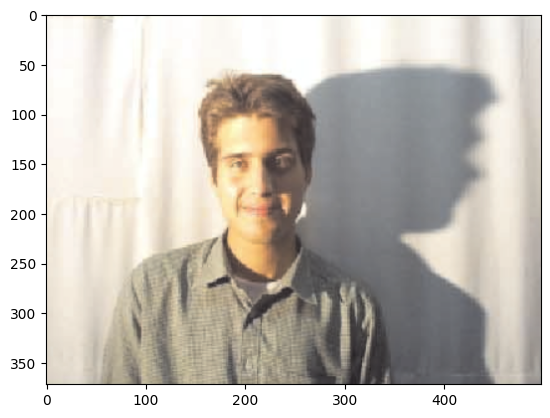

In [9]:
plt.imshow(lux_corrected_image)
plt.show()

In [10]:
crcb = ycc[..., 1:]

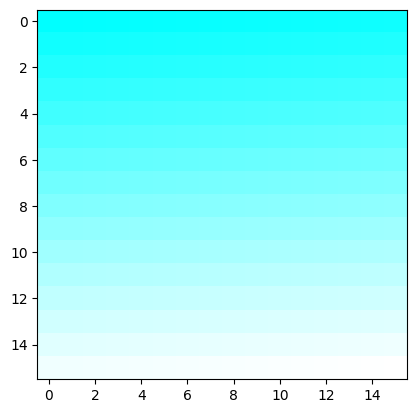

In [11]:
# eyemap = ycc[..., 1] ** 4 * ycc[..., 2] ** 4
red = np.arange(0, 256).reshape(16,16)
ch = np.ones_like(red) * 255
img = np.stack([red,ch,ch], -1)
plt.imshow(img)

In [62]:
class BaseParam:
    w: float
    wl: float
    wh: float

    kl = 125
    kh = 188
    ymin = 16
    ymax = 235

    @classmethod
    def transform(cls, y: float, c: float):
        if cls.kl <= y <= cls.kh:
            return c
        return (c - cls.center(y, c)) * cls.w / cls.cluster(y) + cls.center(cls.kh, c)
    
    @classmethod
    def cluster(cls, y: float):
        if y < cls.kl:
            return cls.wl + (y - cls.ymin) * (cls.w - cls.wl) / (cls.kl - cls.ymin)
        if cls.kh < y:
            return cls.wh + (cls.ymax - y) * (cls.w - cls.wh) / (cls.ymax - cls.kh)
        return cls.ymin

    @classmethod
    def center(cls, y: float, c: float) -> float:
        raise NotImplementedError

class CR(BaseParam):
    w = 38.76
    wl = 20
    wh = 10

    @classmethod
    def center(cls, y: float, c: float) -> float:
        if y < cls.kl:
            return 154 - (cls.kl - y) * (154 - 144) / (cls.kl - cls.ymin)
        if cls.kh < y:
            return 154 + (y - cls.kh) * (154 - 132) / (cls.ymax - cls.kh)
        return c

class CB(BaseParam):
    w = 46.97
    wl = 23
    wh = 14

    @classmethod
    def center(cls, y: float, c: float) -> float:
        if y < cls.kl:
            return 108 + (cls.kl - y) * (118 - 108) / (cls.kl - cls.ymin)
        if cls.kh < y:
            return 108 + (y - cls.kh) * (118 - 108) / (cls.ymax - cls.kh)
        return c


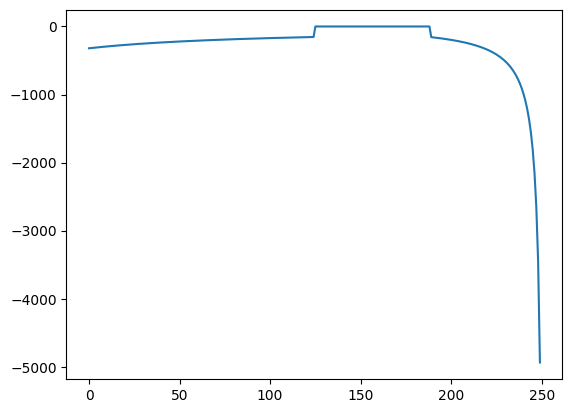

In [63]:
res_cb = [CR.transform(i, 0) for i in range(0, 250)]
plt.plot(res_cb)
plt.show()

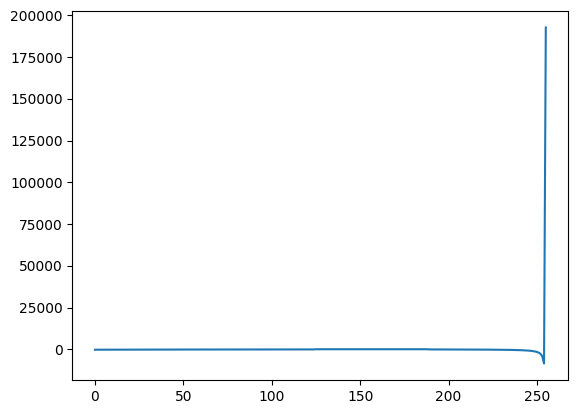

In [32]:
def transform(ycc: np.ndarray):
    transformed = ycc.copy()
    for i, line in enumerate(ycc):
        for j, (y, cr, cb) in enumerate(line):
            transformed[i, j, 1] = CR.transform(y, cr)
            transformed[i, j, 2] = CB.transform(y, cb)
    
    return transformed

transformed = transform(ycc*255)